# TODOs


# Introduction

This notebook will change from the previous in that we will not have all possible action decimation rates available but lets say something along the lines of multiples. i.e. 1,2,4,8.

We will also include the action in the state tape. So that it knows how fast it is going.

Will probably also add replay memory

In [1]:
# Add path forimporting
import sys
sys.path.append('../../')

import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
from time import time
import torch.nn.functional as F
from sp_sims.simulators.stochasticprocesses import BDStates
from sp_sims.utils.utils import get_q_mat
from samprecon.environments.Environments import MarkovianUniformCumulativeEnvironment
from samprecon.samplers.agents import SoftmaxAgent 
from samprecon.reconstructors.NNReconstructors import RNNReconstructor
from samprecon.utils.rl_utils import calculate_returns
from samprecon.estimators.value_estimators import SequenceValue, ValueFunc
from samprecon.feedbacksigs.feedbacks import LogEstimator
from tqdm.notebook import tqdm
import torch

# Send random seeds
np.random.seed(0)
torch.manual_seed(0)


# Initialize context first
device = "cpu"
# Check for Mac M1 and Cuda
if torch.cuda.is_available():
    device = "cuda:0"
    print("Running on GPU")
elif "arm64" in sys.version.lower():
    device = "mps"
    print("Running on Mac M1")


plt.style.use('rose-pine-dawn')
rnd.seed(int(time()))
%load_ext autoreload
%autoreload 2

Running on GPU


In [2]:
# Generate Environments on which to learn
high_res_delta = 1e-0  # For generating the dataset and later sample
num_states = 4
baseline_rates = {"lam": 1 / 10, "mu": 4 / 10}
true_q = torch.from_numpy(get_q_mat(baseline_rates,num_states)).to(torch.float32).to(device)
epochs = 400
length_of_episode = 8
sampling_budget = 64
batch_size = 16
epochs_b4_policy_update = 1
policy_learning_rate = 1e-3
value_learning_rate = 1e-2
#used_path_length = 64  # So that we can let the process reach stationarity and take samples from stationary distribution
avg_span = np.mean(1 / np.array(list(baseline_rates.values())))
max_decimation = (
    avg_span / high_res_delta
) * 4  # Max decimation factor #CHECK: Maybe not divide by 2
decimation_steps = [-8,-4,-2,-1,0,1,2,4,8]
# Easier
#current_decimation_factor = torch.LongTensor(
#    [int(avg_span // high_res_delta)]
#).to(device)
# Harder
current_decimation_factor = torch.randint(1, int(max_decimation), (1,))

print(f"Decimation factor is {current_decimation_factor}")
# Set random seed with time for randomnessj

Decimation factor is tensor([21])


# Declarations

In [3]:
state_generator = BDStates(baseline_rates, high_res_delta, num_states)
# sampling_arbiter.initialize_grad_hooks()
q_recon_criterion = torch.nn.MSELoss(reduction='none')
feedback_Qest = LogEstimator(true_q,10,num_states,q_recon_criterion)
#reconstructor.initialize_grad_hooks()
#valueEst = SequenceValue(num_states+1,1).to(device)
valueEst = ValueFunc(sampling_budget+1, 1).to(device)
gamma = 0.9

# RL Loop

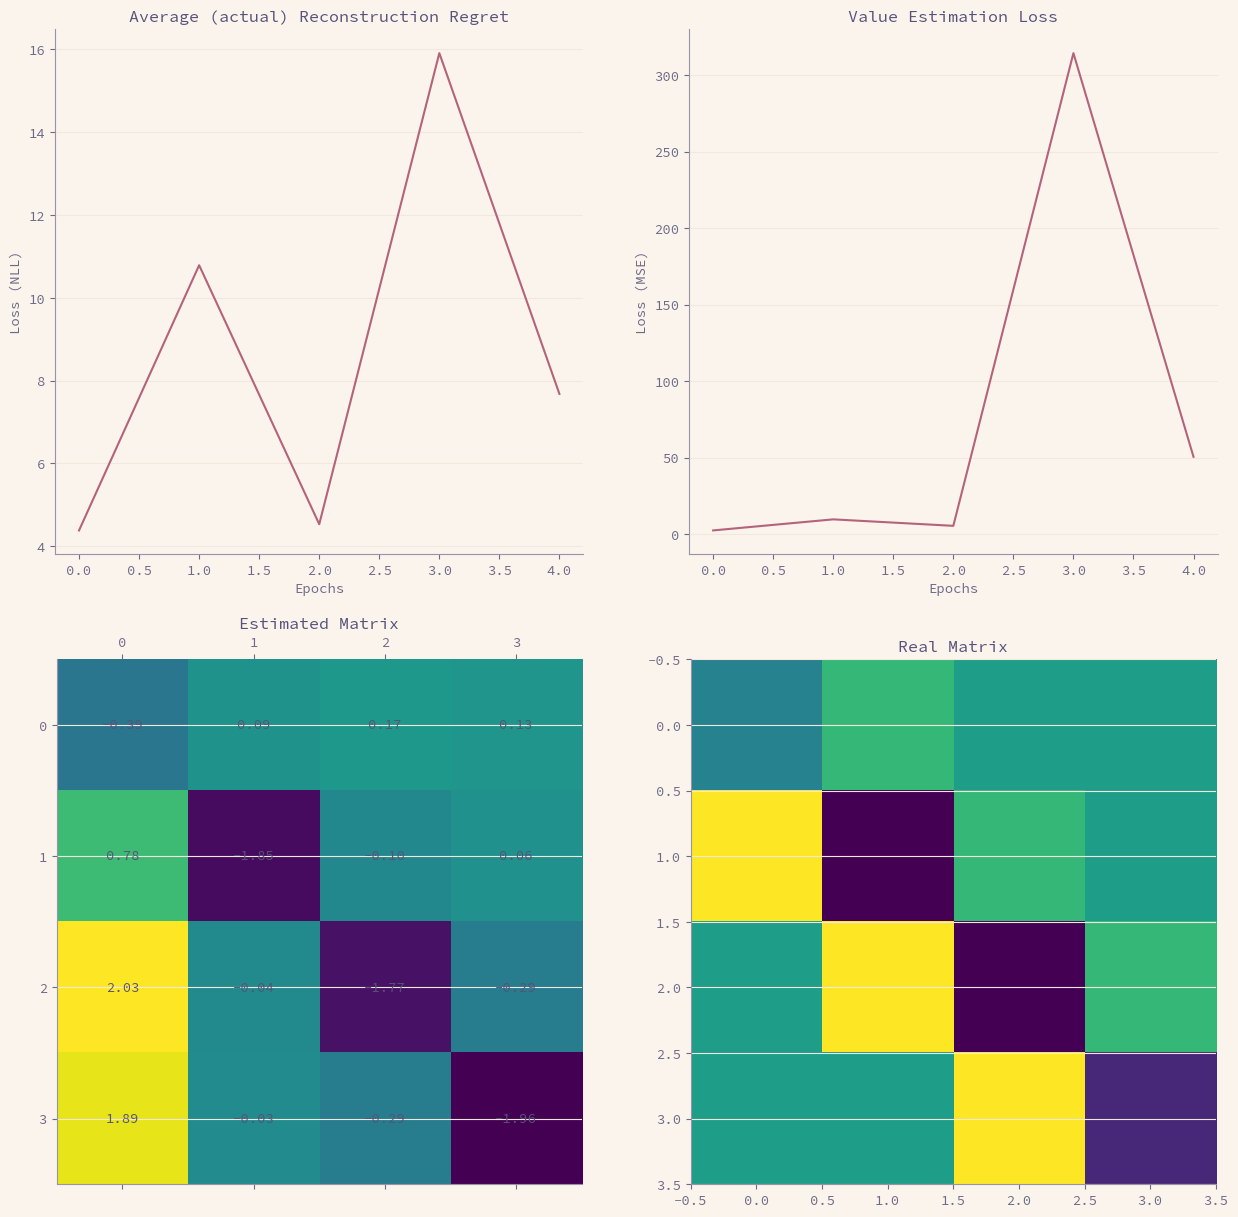

In [9]:
import copy
#from matplotlib.animation import FuncAnimation
from IPython import display
%matplotlib inline


# Set up figure
e_returns = []
est_loss = []
val_losses = [] 
current_matrix = torch.zeros((num_states,num_states))
true_mat = true_q.to("cpu").detach().numpy()



def anim_init_func():
    line0.set_data = ([],[])
    line1.set_data = ([],[])
    mat_display.set_data = (np.zeros((num_states,num_states), aspect='auto'))

def animate(i):
    line0.set_data = (range(len(e_returns)), e_returns)
    line1.set_data = (range(len(val_losses)), val_losses)
    mat_display.set_data = current_matrix.to("cpu").detach().numpy()


env = MarkovianUniformCumulativeEnvironment(
    state_generator=state_generator,
    feedback=feedback_Qest,
    starting_decrate=current_decimation_factor,
    max_decimation = max_decimation,
    sampling_budget=sampling_budget,
)
ebar = tqdm(range(epochs), desc="Epochs", position=0)
sampling_agent = SoftmaxAgent(sampling_budget+1, len(decimation_steps)).to(device)# +1 for the decimation factor
# sampling_agent.initialize_grad_hooks()
optimizer_policy = torch.optim.Adam(sampling_agent.parameters(), lr=policy_learning_rate)
optimizer_value_est = torch.optim.Adam(valueEst.parameters(), lr=value_learning_rate)
t_decsteps = torch.LongTensor(decimation_steps).to(device)
# val_opt = torch.optim.Adam(valueEst.parameters(), lr=1e-2)

# Scheduler with warmpu
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, eta_min=1e-5)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
value_last_weights = list(valueEst.state_dict().values())
sampler_last_weights = list(sampling_agent.state_dict().values())
for epoch in range(epochs):
    # We generate a single step from the generator process
    regrets = []
    log_probs = []
    val_ests = []

    current_decimation_factor = torch.randint(1, int(max_decimation), (batch_size,1)).to(device)

    init_states = torch.randint(0, num_states, (batch_size,1)).to(device)

    # Initial State
    sampled_tape, fullres_tape = env.reset(current_decimation_factor, init_states)
    states = [
        torch.cat(
            (
                current_decimation_factor,
                sampled_tape
            ),
            dim=-1,
        )
    ]
    # TODO: randomly select current_decimation_factor within some bounds
    for step in range(length_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        cur_state = states[-1].to(torch.float)
        action_probs = sampling_agent.act(cur_state)
        #print("Action probs are", action_probs)
        action_probs = action_probs.to(device)
        dist = torch.distributions.Categorical(action_probs)

        sampled_action = (dist.sample()).to(
            device
        )  # So as to not sample 0 (and end up dividing by zero)
        
        # pick from decimation_steps with 
        selected_actions = t_decsteps[sampled_action].view(-1,1).to(device)
        #current_decimation_factor = torch.clamp(current_decimation_factor + selected_actions, 1, int(max_decimation))
        
        val_ests.append(valueEst(cur_state).to(device))

        new_state, regret, done, feedback = env.step(cur_state.to(torch.long), selected_actions)
        current_matrix = feedback["avg_estimated_Q"]

        states.append(new_state.to(device))
        regrets.append(regret)
        log_probs.append(dist.log_prob(sampled_action))


    regrets = torch.stack(regrets).T

    log_probs = torch.stack(log_probs).T 
    val_ests = torch.cat(val_ests, dim=-1)
    returns = calculate_returns(regrets, gamma)

    e_returns.append(returns[:,0].mean().item()) # For logging mostly
    policy_regrets = []
    value_loss = []

    # Learning from steps
    k = 0
    for lp, val_est, ret, reg in zip(log_probs[:,:3].T, val_ests[:,:3].T, returns[:,:3].T, regrets[:,:3].T):
        disadvantage = ret - val_est.detach() # Need detach otherwise we get double backprop error
        policy_regrets.append(
            -lp * disadvantage
        )  # TODO: this might require a negative sign
        #value_loss.append(
        #    F.mse_loss(val_est, torch.Tensor([r.item()]).view(1, -1).to(device))
        #)

        # Change the value estimation to TD learning
        current_value_est = val_est
        next_value = val_ests[:,k+1]
        target = reg + gamma * next_value
        value_loss.append(
            F.mse_loss(current_value_est, target.detach())
        )

        k+=1
    # We update the whole thingko
    policy_loss = torch.stack(policy_regrets).sum()
    value_loss = torch.stack(value_loss).mean()

    val_losses.append(value_loss.item())

    # optimze:
    optimizer_policy.zero_grad()
    optimizer_value_est.zero_grad()
    if epoch % epochs_b4_policy_update == 0:
        policy_loss.backward()
        optimizer_policy.step()
    value_loss.backward()
    optimizer_value_est.step()
    #scheduler.step()

    # 🐛 Debugging
    #differences = []
    #for i, v in enumerate(sampling_agent.state_dict().values()):
    #    differences.append(torch.sum(torch.abs(v - sampler_last_weights[i])))
    #differences_arbitrer = torch.sum(torch.tensor(differences))
    ## hard copy last weights
    #sampler_last_weights = [
    #    copy.deepcopy(v) for v in sampling_agent.state_dict().values()
    #]
    #differenes = []
    #for i,v in enumerate(valueEst.state_dict().values()):
    #    differences.append(torch.sum(torch.abs(v - value_last_weights[i])))
    #differences_value = torch.sum(torch.Tensor(differences))
    #value_last_weights = [
    #    copy.deepcopy(v) for v in valueEst.state_dict().values()
    #]
    #print(
    #    f"Differences are : Sampler: {differences_arbitrer}, Value Estimator: {differences_value}"
    #)
    # 🐛 End Debuggin

    fig,axs = plt.subplots(2,2, figsize=(15,15))
    axs[0,0].set_title("Average (actual) Reconstruction Regret")
    axs[0,0].set_xlabel("Epochs")
    axs[0,0].set_ylabel("Loss (NLL)")
    axs[0,0].plot(e_returns)

    axs[0,1].set_title("Value Estimation Loss")
    axs[0,1].set_xlabel("Epochs")
    axs[0,1].set_ylabel("Loss (MSE)")
    axs[0,1].plot(val_losses)
    axs[1,0].set_title("Estimated Matrix")
    axs[1,0].imshow(current_matrix.to("cpu").detach().numpy())
    mat_display = axs[1,0].matshow(current_matrix.to("cpu").detach().numpy())
    axs[1,1].set_title("Real Matrix")
    axs[1,1].imshow(true_mat)


    for i in range(current_matrix.shape[0]):
        for j in range(current_matrix.shape[1]):
            cest = current_matrix[i,j]
            ctrue = true_mat[i,j]
            axs[1,0].text(j,i, f"{cest:.2f}", va='center', ha='center')
            axs[1,1].text(j,i, f"{ctrue:.2f}", va='center', ha='center')
    display.display(plt.gcf())
    display.clear_output(wait=True)


    moving_avg_loss = np.mean(e_returns[-3:]) if epoch > 3 else np.mean(e_returns)
    ebar.set_description(f"Epoch Mean Regret: {moving_avg_loss}")
    ebar.update(1)
    # We get reward based on how close we got to maximum information
    # Show Losses

In [ ]:
# Get time in nice format
from datetime import datetime
now = datetime.now()
date_time  = now.strftime("%m-%d-%Y_%H-%M-%S")

# SaveModels 
torch.save(reconstructor.state_dict(), f"models/reconstructor_{date_time}.pt")
torch.save(sampling_agent.state_dict(), f"models/sampling_agent_{date_time}.pt")

NameError: name 'reconstructor' is not defined

In [ ]:
from samprecon.samplers.spatial_transformers import differentiable_uniform_sampler
def hard_decimation_of_state(high_freq_signal: torch.Tensor, rate: int, sampling_budget:int, num_classes:int):
    blank_slate = torch.zeros_like(high_freq_signal)
    seq_len = len(blank_slate)
    samples = high_freq_signal[::rate][:sampling_budget]
    for i,sample in enumerate(samples):
        blank_slate[i*rate] = sample
    # turn blank_slate into one hot
    one_hot = F.one_hot(blank_slate.to(torch.long), num_classes=num_classes).view(1,-1,num_classes)
    return one_hot


sampling_agent.eval()
reconstructor.eval()

chosen_actions = []

# Visually confirm proper reconstruction. 
num_examples = 3

fig, axs = plt.subplots(num_examples,2, figsize=(15,10))
# Start with some previous state. 


for ne in range(num_examples):

    regrets = []
    val_ests = []
    sbar.reset()

    actions_taken = []

    current_decimation_factor = torch.randint(1, int(max_decimation), (1,)).to(device)
    decimation_rates = []

    # Initial State
    states = [
        torch.cat(
            (
                torch.Tensor([current_decimation_factor]).to(device).view(1,1),
                env.reset(current_decimation_factor).view(1, -1).to(device),
            ),
            dim=-1,
        )
    ]

    for step in range(length_of_episode):
        # with torch.autograd.set_detect_anomaly(True):
        cur_state = states[-1]
        action_probs = sampling_agent.act(cur_state[:sampling_budget+2])# CHECK why smapling_budget + 2
        #print("Action probs are", action_probs)
        action_probs = action_probs.to(device)
        sampled_action = torch.argmax(action_probs,dim=-1)

        actions_taken.append(sampled_action.item())
        
        # CHECK: If we should have computation graph *not* cutting here
        current_decimation_factor += decimation_steps[sampled_action.item()]
        current_decimation_factor = torch.LongTensor([int(max(1,min(current_decimation_factor, max_decimation)))])
        decimation_rates.append(current_decimation_factor.item())
        
        # TODO: tensorize
        dec_steps = (
            torch.arange(
                0,
                current_decimation_factor.item() * sampling_budget,
                current_decimation_factor.item(),
            )
            .view(-1, 1)
            .to(device)
        )
        one_hot_cur_state = F.one_hot(
            cur_state[0,1:sampling_budget+1].to(torch.long), num_classes=num_states
        ).to(device)

        non_amb_state = (
            torch.cat((one_hot_cur_state, dec_steps), dim=-1).to(torch.float).to(device)
        ).view(1,sampling_budget,-1)
        val_ests.append(valueEst(non_amb_state).to(device))

        new_state, regret, done = env.step(current_decimation_factor)

        new_state_w_rate = torch.cat(
                (
                    torch.Tensor([current_decimation_factor]).to(device).view(1,1),
                    new_state
                ),
                dim=-1,
            )

        states.append(new_state_w_rate.to(device))
        regrets.append(regret)

        sbar.set_description(f"At step {step}, Regret: {regret}")
        sbar.update(1)

    final_action = torch.argmax(sampling_agent.act(states[-1][:sampling_budget+2]),dim=-1)
    final_dec_factor = current_decimation_factor.item() + final_action
    final_state = torch.LongTensor(env.state_generator.sample(final_dec_factor, sampling_budget)).to(device)
    final_state_oh = F.one_hot(final_state.view(1, -1).to(torch.long), num_classes=state_generator.max_state + 1).float()

    #final_dec_state = hard_decimation_of_state(final_state, final_dec_factor, sampling_budget, num_states)
    final_dec_state = differentiable_uniform_sampler(final_state_oh, final_dec_factor)

    final_sm = F.softmax(env.reconstructor(final_dec_state,final_dec_factor),dim=-1)
    final_reconstruction = torch.argmax(final_sm,dim=-1).cpu().detach().numpy().squeeze()


    print(f"Lenght of final state is {len(final_state)}")

    # Do plotting here
    entire_x = np.arange(0,high_res_delta*(len(final_state)),step=high_res_delta)
    axs[ne,0].plot(entire_x, final_state,drawstyle="steps-post",label="Full resolution")#, marker="^",markersize=3)
    # Plot Samples
    dec_x = np.arange(0,(sampling_budget*final_dec_factor),step=finaL_dec_factor)
    axs[ne,0].scatter(dec_x, final_state[::int(final_dec_factor)][:sampling_budget], label="Decimated", marker="o",color='r',s=30)
    axs[ne,0].set_title(f"Results for Experiment {ne+1}")

    # Plot Reconstrunction
    axs[ne,0].plot(entire_x, final_reconstruction, label="Reconstruction")#, marker="x",markersize=3)
    axs[ne,0].legend()

    # History of Actions
    axs[ne,1].plot(np.arange(len(decimation_rates)),decimation_rates)
plt.tight_layout()
plt.show()
    
print(f"Choices of actions were {chosen_actions}")

Lenght of final state is 590
